In [1]:

import os, sys, subprocess, time
import toml
from MOASMO_parameters import generate_initial_parameter_sets, surrogate_model_train_and_pareto_points
import run_multiple_paramsets

In [2]:
bnum  = 30

########################################################################################################################
# load configurations
# config_file = 'config.toml'
# config = toml.load(config_file)

ostrich_file = f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_{bnum}_OstCalib/run/CTSM_run_trial.sh'
with open(ostrich_file, 'r') as f:
    ostlines = f.readlines()

# inputs
file_parameter_list = '/glade/u/home/guoqiang/CTSM_repos/moasmo_test/param_ASG_20221206_moasmo.csv'
path_CTSM_base = f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_{bnum}'
script_singlerun = '/glade/u/home/guoqiang/CTSM_repos/moasmo_test/run_one_paramset.py'
script_clone = '/glade/u/home/guoqiang/CTSM_repos/CTSM/cime/scripts/create_clone'
ref_streamflow = f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_{bnum}_OstCalib/refdata/streamflow_data.csv'

for l in ostlines:
    if l.startswith('add_flow_file'):
        add_flow_file = l.strip().split('#')[0].strip().split('=')[1].replace('"', '')
        break

# outputs
path_paramset = f'/glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS{bnum}/param_sets'
path_submit = f'/glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS{bnum}/run_model'
path_archive = f'/glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS{bnum}/ctsm_outputs'

# evaluation period
for l in ostlines:
    if l.startswith('DateEvalStart'):
        date_start = l.strip().split('#')[0].strip().split('=')[1]
        break

for l in ostlines:
    if l.startswith('DateEvalEnd'):
        date_end = l.strip().split('#')[0].strip().split('=')[1]
        break

# MO-ASMO parameters
sampling_method = 'glp'
num_init = 36 # initial number of samples
num_per_iter = 20 # number of selected pareto parameter sets for each iteration
num_iter = 4 # including the initial iteration

########################################################################################################################
# MO-ASMO main

file_metric_all = []
file_param_all = []

In [5]:
    it = 0

    iterflag = it
    
    if it == 0:
        # Initial sampling which generates many parameter sets
        print('Generating initial parameters')
        # init_param_filelist = generate_initial_parameter_sets(file_parameter_list, sampling_method, path_paramset, path_CTSM_base, num_init)
        sample_num = num_init
    else:
        sample_num = num_per_iter

    file_param_all = [f'/glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS{bnum}/ctsm_outputs/iter0_all_meanparam.csv', 
                     f'/glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS{bnum}/ctsm_outputs/iter1_all_meanparam.csv', ]
    
    
    file_metric_all = [f'/glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS{bnum}/ctsm_outputs/iter0_all_metric.csv',
                      f'/glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS{bnum}/ctsm_outputs/iter1_all_metric.csv',]
    
    

Generating initial parameters


In [6]:
    surrogate_model_train_and_pareto_points(file_parameter_list, file_param_all, file_metric_all, path_paramset, iterflag, num_per_iter, path_CTSM_base)


Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS30/param_sets/paramset_iter1_trial0.csv
Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS30/param_sets/paramset_iter1_trial1.csv
Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS30/param_sets/paramset_iter1_trial2.csv
Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS30/param_sets/paramset_iter1_trial3.csv
Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS30/param_sets/paramset_iter1_trial4.csv
Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS30/param_sets/paramset_iter1_trial5.csv
Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS30/param_sets/paramset_iter1_trial6.csv
Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS30/param_sets/paramset_iter1_trial7.csv
Generating parameter file: /glade/work/guoqiang/CTSM_cases/MOASM

In [7]:
# functions for generating and saving MO-ASMO parameter sets, including initial and non-dominant parameters
import os, sys, subprocess, pickle
import numpy as np
import pandas as pd
import xarray as xr
import pickle

# import MO-ASMO functions
# path_MOASMO = '/glade/u/home/guoqiang/model_sources/MO-ASMO/src'
path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
sys.path.append(path_MOASMO)
import sampling
import gp
import NSGA2

def get_parameter_from_Namelist_or_lndin(name, file_user_nl_clm, file_lndin, type='number'):
    # check Namelist file first, and then check
    with open(file_user_nl_clm, 'r') as f:
        for l in f:
            l = l.strip()
            if l.startswith(name):
                if type == 'number':
                    value = np.array(float(l.split('=')[-1].strip().replace('\'', '')))
                elif type == 'str':
                    value = l.split('=')[-1].strip().replace('\'', '')
                flag = True
                break
    if not flag:
        with open(file_lndin, 'r') as f:
            for l in f:
                l = l.strip()
                if l.startswith(name):
                    value = np.array(float(l.split('=')[-1].strip().replace('\'', '')))
                elif type == 'str':
                    value = l.split('=')[-1].strip().replace('\'', '')
                    break
    return value


def get_parameter_value_from_CTSM_case(param_name, param_source, path_CTSM_case):
    # get the parameter values of an existing CTSM case

    file_user_nl_clm = f'{path_CTSM_case}/user_nl_clm'
    file_lndin = f'{path_CTSM_case}/Buildconf/clmconf/lnd_in'

    if param_source == 'Namelist':
        param_value = get_parameter_from_Namelist_or_lndin(param_name, file_user_nl_clm, file_lndin, 'number')
    elif param_source == 'Param':
        paramfile = get_parameter_from_Namelist_or_lndin('paramfile', file_user_nl_clm, file_lndin, 'str')
        with xr.open_dataset(paramfile) as ds:
            param_value = ds[param_name].values
    elif param_source == 'Surfdata':
        fsurdat = get_parameter_from_Namelist_or_lndin('fsurdat', file_user_nl_clm, file_lndin, 'str')
        with xr.open_dataset(fsurdat) as ds:
            param_value = ds[param_name].values
    else:
        sys.exit(f'Unknown param_source: {param_source}')

    return param_value


def check_and_generate_binded_parameters(df_param, path_CTSM_case):
    # check if there is any binded variable
    # if there is, add binded variables to df_calibparam
    # it is assumed that binded variables have the same parameter range so we can scale them equally
    if 'Binding' in df_param.columns:
        df_bind = pd.DataFrame()
        for i in range(len(df_param)):
            rawvari_value = get_parameter_value_from_CTSM_case(df_param.iloc[i]['Parameter'], df_param.iloc[i]['Source'], path_CTSM_case)
            bindvari = df_param.iloc[i]['Binding']
            if bindvari != 'None':
                bindvari = bindvari.split(',')
                for bv in bindvari:
                    dftmp = df_param.iloc[[i]].copy()
                    dftmp['Parameter'] = bv
                    # mask other cols
                    for col in ['Default', 'Lower', 'Upper', 'Binding', 'Parameter_Ost']:
                        if col in dftmp.columns:
                            dftmp[col] = 'None'
                    # generate parameter values
                    bind_var_value0 = get_parameter_value_from_CTSM_case(bv, dftmp['Source'].values[0], path_CTSM_case)
                    dftmp['Value'] = bind_var_value0 + (df_param.iloc[i]['Value'] - rawvari_value)
                    df_bind = pd.concat([df_bind, dftmp])

        df_param = pd.concat([df_param, df_bind])

    return df_param


########################################################################################################################
# Initial sampling:
# Generate a TXN matrix X using the Good Lattice Points method with RGS de-correlation,
# where T is the number of sample points. Run the dynamic model for T times and obtain the multiobjective results Y
# Y=f(X)
# where Y is a TXM matrix containing the objective functions


def read_parameter_csv(file_parameter_list):
    df_calibparam = pd.read_csv(file_parameter_list)
    for c in ['Upper', 'Lower', 'Factor', 'Value']:
        if c in df_calibparam.columns:
            if isinstance(df_calibparam.iloc[0][c], str):
                arr = []
                for i in range(len(df_calibparam)):
                    vi = df_calibparam.iloc[i][c]
                    if ',' in vi:
                        arr.append(np.array(vi.split(',')).astype(np.float64))
                    elif '[' in vi:
                        arr.append(np.array(vi.strip('[]').replace('\n', '').split(), dtype=np.float64))
                    else:
                        try:
                            arr.append(np.array([np.float64(vi)]))
                        except:
                            arr.append(np.array([-99999]))
                df_calibparam[c] = arr
    return df_calibparam


def generate_initial_parameter_sets(file_parameter_list, sampling_method, outpath, path_CTSM_case='', num_init=-1):
    # example parameters
    # sampling_method = 'lh'  # lh: LatinHypercubeDesign, slh: SymmetricLatinHypercubeDesign, glp: GoodLatticePointsDesign
    # param_upper_bound = {'param1': np.array(15), 'param2': np.array([1, 2, 3])}
    # param_lower_bound = {'param1': np.array(3), 'param2': np.array([0.2, 1.5, 2.2])}
    # path_CTSM_case must be provided if there are any binded parameters for calibration

    os.makedirs(outpath, exist_ok=True)

    df_calibparam = read_parameter_csv(file_parameter_list)
    param_upper_bound = df_calibparam['Upper'].values
    param_lower_bound = df_calibparam['Lower'].values

    # dimension sizes
    num_param = len(param_lower_bound) # number of parameters to be calibrated
    if not num_init > 0:
        num_init = num_param * 20 # number of initial samples (i.e., initial model runs). A proper initial sample size should be 15–20 times the number of parameters (Gong et al., 2015)

    # get initial factors between 0 and 1 which will be used to scale real parameters
    # init_factors: [num_init, num_param]
    if sampling_method == 'lh':
        init_factors = sampling.lh(num_init, num_param)
    elif sampling_method == 'slh':
        init_factors = sampling.slh(num_init, num_param)
    elif sampling_method == 'glp': # glp is used by Gong et al., 2015
        init_factors = sampling.glp(num_init, num_param)
    else:
        sys.exit('Unknown sampling method!')

    # save factors
    df_factor = pd.DataFrame(init_factors, columns=df_calibparam['Parameter'].values)
    df_factor.to_csv(f'{outpath}/paramset_iter0_scalefactors.csv', index=False)

    # generate a dataframe for every set of parameters and deal with binding parameters
    outfiles_all = []
    for i in range(num_init):
        outfile = f'{outpath}/paramset_iter0_trial{i}.csv'
        print('Generating parameter file:', outfile)
        dfi = df_calibparam.copy()
        dfi['Factor'] = init_factors[i, :]
        dfi['Value'] = init_factors[i, :] * (param_upper_bound - param_lower_bound) + param_lower_bound

        # process binded parameters
        dfi = check_and_generate_binded_parameters(dfi, path_CTSM_case)

        dfi.to_csv(outfile, index=False)
        outfiles_all.append(outfiles_all)



########################################################################################################################
# Pareto optimal points:

def surrogate_model_train_and_pareto_points(param_infofile, param_filelist, metric_filelist, outpath, iterflag, num_per_iter, path_CTSM_case=''):
    # path_CTSM_case must be provided if there are any binded parameters for calibration

    # define hyper parameters
    pop = 100
    gen = 100
    crossover_rate = 0.9
    mu = 20
    mum = 20

    # define hyperparameter
    alpha = 1e-3
    leng_lb = 1e-3
    leng_ub = 1e3
    nu = 2.5

    n_sample = num_per_iter # number of selected optimal points

    # input data x (parameter sets) and output data y (objective function values)
    df_param = pd.concat(map(pd.read_csv, param_filelist))
    df_metric = pd.concat(map(pd.read_csv, metric_filelist))
    df_info = read_parameter_csv(param_infofile)

    param_names = df_info['Parameter'].values # exclude binded parameters
    df_param = df_param[param_names]

    xlb_mean = np.array([np.nanmean(v) for v in df_info['Lower']])
    xub_mean = np.array([np.nanmean(v) for v in df_info['Upper']])

    x = df_param.to_numpy()
    y = df_metric.to_numpy()

    nInput = x.shape[1]
    nOutput = y.shape[1]

    # train the surrogate model
    # https://github.com/NCAR/ctsm_optz/blob/89e3689e73180574c62d1f5aa555a57e886a7cec/workflow/scripts/MOASMO_onestep.pe_basin.py#LL311C1-L315C41
    # sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)
    # os.makedirs(outpath, exist_ok=True)
    # sm_filename = f'{outpath}/surrogate_model_for_iter{iterflag}'
    # pickle.dump(sm, open(sm_filename, 'wb'))

    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    sm = RandomForestRegressor()
    sm.fit(x, y)
    os.makedirs(outpath, exist_ok=True)
    sm_filename = f'{outpath}/surrogate_model_for_iter{iterflag}'
    pickle.dump(sm, open(sm_filename, 'wb'))


    # perform optimization using the surrogate model
    bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum)
    D = NSGA2.crowding_distance(besty_sm)
    idxr = D.argsort()[::-1][:n_sample]
    x_resample = bestx_sm[idxr, :]
    y_resample = besty_sm[idxr, :]
    # y_resample = sm.predict(x_resample)

    # # plot
    # import matplotlib.pyplot as plt
    # plt.scatter(y[:, 0], y[:, 1])
    # plt.scatter(besty_sm[:, 0], besty_sm[:, 1])
    # plt.scatter(besty_sm[idxr, 0], besty_sm[idxr, 1])

    param_upper_bound = df_info['Upper'].values
    param_lower_bound = df_info['Lower'].values

    # generate a parameter dataframe for next trial
    for i in range(x_resample.shape[0]):
        outfile = f'{outpath}/paramset_iter{iterflag+1}_trial{i}.csv'
        print('Generating parameter file:', outfile)

        dfi = df_info.copy()
        factors = (x_resample[i, :] - xlb_mean) / (xub_mean - xlb_mean)
        factors[factors<0] = 0.01
        factors[factors>1] = 0.99
        dfi['Factor'] = factors
        dfi['Value'] = factors * (param_upper_bound - param_lower_bound) + param_lower_bound

        # process binded parameters
        dfi = check_and_generate_binded_parameters(dfi, path_CTSM_case)

        # write
        dfi.to_csv(outfile, index=False)



In [8]:
param_infofile, param_filelist, metric_filelist, outpath, iterflag, num_per_iter, path_CTSM_case = file_parameter_list, file_param_all, file_metric_all, path_paramset, iterflag, num_per_iter, path_CTSM_base

In [9]:
    # define hyper parameters
    pop = 100
    gen = 100
    crossover_rate = 0.9
    mu = 20
    mum = 20

    # define hyperparameter
    alpha = 1e-3
    leng_lb = 1e-3
    leng_ub = 1e3
    nu = 2.5

    n_sample = num_per_iter # number of selected optimal points

    # input data x (parameter sets) and output data y (objective function values)
    df_param = pd.concat(map(pd.read_csv, param_filelist))
    df_metric = pd.concat(map(pd.read_csv, metric_filelist))
    df_info = read_parameter_csv(param_infofile)

    param_names = df_info['Parameter'].values # exclude binded parameters
    df_param = df_param[param_names]

    xlb_mean = np.array([np.nanmean(v) for v in df_info['Lower']])
    xub_mean = np.array([np.nanmean(v) for v in df_info['Upper']])

    x = df_param.to_numpy()
    y = df_metric.to_numpy()

    nInput = x.shape[1]
    nOutput = y.shape[1]

    # train the surrogate model
    # https://github.com/NCAR/ctsm_optz/blob/89e3689e73180574c62d1f5aa555a57e886a7cec/workflow/scripts/MOASMO_onestep.pe_basin.py#LL311C1-L315C41
    # sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)
    # os.makedirs(outpath, exist_ok=True)
    # sm_filename = f'{outpath}/surrogate_model_for_iter{iterflag}'
    # pickle.dump(sm, open(sm_filename, 'wb'))
    
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    sm = RandomForestRegressor()
    sm.fit(x, y)
    os.makedirs(outpath, exist_ok=True)
    sm_filename = f'{outpath}/surrogate_model_for_iter{iterflag}'
    pickle.dump(sm, open(sm_filename, 'wb'))


    # perform optimization using the surrogate model
    bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum)
    D = NSGA2.crowding_distance(besty_sm)
    idxr = D.argsort()[::-1][:n_sample]
    x_resample = bestx_sm[idxr, :]
    y_resample = besty_sm[idxr, :]

In [20]:
xlb_mean

array([ 2.00000000e+04,  2.50000000e-01, -1.00000000e+01,  1.00000000e-02,
        1.00000000e+00,  2.50000000e-02,  5.00000000e-04,  2.00000000e-01,
        9.00000000e-01,  5.82658228e-11,  5.00000000e+00,  2.50000000e-01,
        5.00000000e-02])

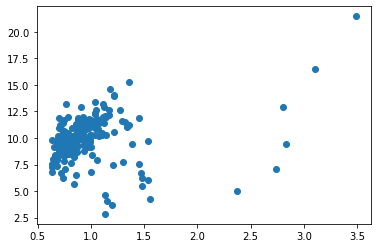

In [17]:
import matplotlib.pyplot as plt
plt.scatter(y[:200,0], y[:200,1])
# plt.scatter(besty_sm[:,0], besty_sm[:,1])

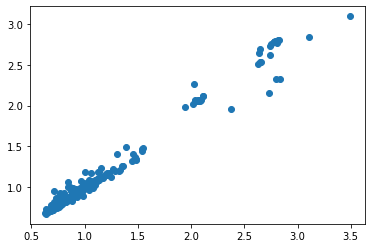

In [11]:
y2 = sm.predict(x)
plt.scatter(y[:,0], y2[:,0])

In [73]:
xlb_mean, xub_mean,alpha, [leng_lb, leng_ub], nu

(array([ 2.00000000e+04,  2.50000000e-01, -1.00000000e+01,  1.00000000e-02,
         1.00000000e+00,  2.50000000e-02,  5.00000000e-04,  2.00000000e-01,
         9.00000000e-01,  5.82658228e-11,  5.00000000e+00,  2.50000000e-01,
         5.00000000e-02]),
 array([ 2.5000000e+05,  2.0000000e+00, -5.0000000e-01,  1.0000000e+01,
         8.0000000e+00,  4.0000000e+00,  1.0000000e-01,  8.0000000e-01,
         9.0000000e+00,  6.8964557e-09,  1.0000000e+02,  2.0000000e+00,
         1.5000000e-01]),
 0.001,
 [0.001, 1000.0],
 2.5)

In [79]:
from sklearn import preprocessing
param_train_df = df_param.copy()
d = preprocessing.normalize(param_train_df,axis=0,return_norm=True)
normalization_scalar = d[1]

In [80]:
scaled_df = param_train_df/normalization_scalar
scaled_df.tail()

,vcmaxha,om_frac_sf,slopebeta,fff,e_ice,liq_canopy_storage_scalar,baseflow_scalar,FMAX,hksat_sf,krmax,d_max,frac_sat_soil_dsl_init,a_coef
211,0.110901,0.018934,-0.085823,0.113162,0.042626,0.033435,0.062050,0.067329,0.021673,0.041125,0.024185,0.109677,0.073392
212,0.111382,0.037261,-0.113611,0.066855,0.036814,0.097214,0.096708,0.074473,0.100441,0.033045,0.042373,0.090456,0.065221
213,0.111864,0.055589,-0.031763,0.020547,0.031003,0.043704,0.013855,0.081617,0.078069,0.024964,0.060562,0.071234,0.057049
214,0.112346,0.073916,-0.059551,0.092460,0.025192,0.107483,0.048512,0.088760,0.055697,0.016883,0.078750,0.052013,0.048878
215,0.112827,0.092244,-0.087339,0.046153,0.019381,0.053974,0.083170,0.095904,0.033325,0.008803,0.096939,0.032791,0.040706


In [81]:
xlb_single_value_scaled = xlb_mean/normalization_scalar
xub_single_value_scaled = xub_mean/normalization_scalar

In [82]:
# start training the surrogate models
x = scaled_df.values #param_df.values #.shape[0]
y = df_metric.values #norm_metric_mean.T.values


In [120]:
alpha = 1e-3
lb = 1e-3
ub = 1e3
nu = 10

# sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_single_value_scaled, xub_single_value_scaled,alpha=alpha, leng_sb=[lb,ub], nu=nu)
sm = gp.GPR_Matern(x, y, 13, nOutput, 216, xlb_single_value_scaled, xub_single_value_scaled,alpha=alpha, leng_sb=[lb,ub], nu=nu)


In [134]:
np.savez_compressed('/glade/u/home/guoqiang/CTSM_repos/moasmo_test/test.npz', x=x, y=y, nOutput=nOutput, xlb_single_value_scaled=xlb_single_value_scaled, xub_single_value_scaled=xub_single_value_scaled, alpha=alpha, lb=lb, ub=ub, nu=nu) 

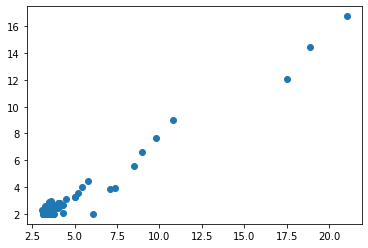

In [121]:
y2 = sm.predict(x)
plt.scatter(y[:,0], y2[:,0])

In [99]:
    # perform optimization using the surrogate model
    bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm, nInput, nOutput, xlb_single_value_scaled, xub_single_value_scaled, pop, gen, crossover_rate, mu, mum)
    D = NSGA2.crowding_distance(besty_sm)
    idxr = D.argsort()[::-1][:n_sample]
    x_resample = bestx_sm[idxr, :]
    y_resample = besty_sm[idxr, :]

ValueError: cannot reshape array of size 13 into shape (1,216)

(216, 13)

In [60]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X, y)
gpr.score(X, y)

gpr.predict(X[:2,:], return_std=True)

/glade/work/guoqiang/conda-envs/npl-2022b-tgq/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/guoqiang/conda-envs/npl-2022b-tgq/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(array([653.08792288, 592.16905327]), array([316.68016218, 316.65121679]))

In [62]:
    # define hyper parameters
    pop = 100
    gen = 100
    crossover_rate = 0.9
    mu = 20
    mum = 20

    # define hyperparameter
    alpha = 1e-3
    leng_lb = 1e-3
    leng_ub = 1e3
    nu = 2.5

    n_sample = num_per_iter # number of selected optimal points

    # input data x (parameter sets) and output data y (objective function values)
    df_param = pd.concat(map(pd.read_csv, param_filelist))
    df_metric = pd.concat(map(pd.read_csv, metric_filelist))
    df_info = read_parameter_csv(param_infofile)

    param_names = df_info['Parameter'].values # exclude binded parameters
    df_param = df_param[param_names]

    xlb_mean = np.array([np.nanmean(v) for v in df_info['Lower']])
    xub_mean = np.array([np.nanmean(v) for v in df_info['Upper']])

    x = df_param.to_numpy()
    y = df_metric.to_numpy()
    
    
    gpr = GaussianProcessRegressor(kernel=kernel,
            random_state=0).fit(x, y)
    

/glade/work/guoqiang/conda-envs/npl-2022b-tgq/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [69]:
sm=gpr

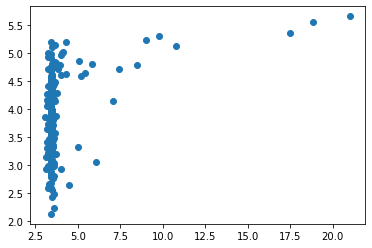

In [68]:
y2=gpr.predict(x)
plt.scatter(y[:,0], y2[:,0])

In [70]:
    os.makedirs(outpath, exist_ok=True)
    sm_filename = f'{outpath}/surrogate_model_for_iter{iterflag}'
    pickle.dump(sm, open(sm_filename, 'wb'))

    # perform optimization using the surrogate model
    bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum)
    D = NSGA2.crowding_distance(besty_sm)
    idxr = D.argsort()[::-1][:n_sample]
    x_resample = bestx_sm[idxr, :]
    y_resample = besty_sm[idxr, :]

AttributeError: 'GaussianProcessRegressor' object has no attribute 'evaluate'

In [ ]:
import sampling
import numpy as np
import copy

def optimization(model, nInput, nOutput, xlb, xub, pop, gen, \
                 crossover_rate = 0.9, mu = 20, mum = 20):
    ''' Nondominated Sorting Genetic Algorithm II, An multi-objective algorithm
        model: the evaluated model function
        nInput: number of model input
        nOutput: number of output objectives
        xlb: lower bound of input
        xub: upper bound of input
        pop: number of population
        gen: number of generation
        crossover_rate: ratio of crossover in each generation
        mu: distribution index for crossover
        mum: distribution index for mutation
    '''
    poolsize = int(round(pop/2.)); # size of mating pool;
    toursize = 2;                  # tournament size;

    x = sampling.lh(pop, nInput)
    x = x * (xub - xlb) + xlb
    y = np.zeros((pop, nOutput))
    for i in range(pop):
        y[i,:] = model.predict(x[i,:])
    icall = pop

    x, y, rank, crowd = sortMO(x, y, nInput, nOutput)
    population_para = x.copy()
    population_obj  = y.copy()

    for i in range(gen):
        pool = selection(population_para, population_obj, nInput, pop, poolsize, toursize)
        count = 0
        while (count < pop - 1):
            if (np.random.rand() < 0.9):
                parentidx = np.random.choice(poolsize, 2, replace = False)
                parent1   = pool[parentidx[0],:]
                parent2   = pool[parentidx[1],:]
                child1, child2 = crossover(parent1, parent2, mu, xlb, xub)
                y1 = model.evaluate(child1)
                y2 = model.evaluate(child2)
                x  = np.vstack((x,child1,child2))
                y  = np.vstack((y,y1,y2))
                population_para = np.vstack((population_para,child1,child2))
                population_obj  = np.vstack((population_obj,y1,y2))
                count += 2
                icall += 2
            else:
                parentidx = np.random.randint(poolsize)
                parent    = pool[parentidx,:]
                child     = mutation(parent, mum, xlb, xub)
                y1 = model.evaluate(child)
                x  = np.vstack((x,child))
                y  = np.vstack((y,y1))
                population_para = np.vstack((population_para,child))
                population_obj  = np.vstack((population_obj,y1))
                count += 1
                icall += 1
        population_para, population_obj = \
            remove_worst(population_para, population_obj, pop, nInput, nOutput)
        bestx = population_para.copy()
        besty = population_obj.copy()
    return bestx, besty, x, y

def sortMO(x, y, nInput, nOutput):
    ''' Non domination sorting for multi-objective optimization
        x: input parameter matrix
        y: output objectives matrix
        nInput: number of input
        nOutput: number of output
    '''
    rank, dom = fast_non_dominated_sort(y)
    idxr = rank.argsort()
    rank = rank[idxr]
    x = x[idxr,:]
    y = y[idxr,:]
    T = x.shape[0]

    crowd = np.zeros(T)
    rmax = int(rank.max())
    idxt = np.zeros(T, dtype = np.int)
    c = 0
    for k in range(rmax):
        rankidx = (rank == k)
        D = crowding_distance(y[rankidx,:])
        idxd = D.argsort()[::-1]
        crowd[rankidx] = D[idxd]
        idxtt = np.array(range(len(rank)))[rankidx]
        idxt[c:(c+len(idxtt))] = idxtt[idxd]
        c += len(idxtt)
    x = x[idxt,:]
    y = y[idxt,:]
    rank = rank[idxt]

    return x, y, rank, crowd

def fast_non_dominated_sort(Y):
    ''' a fast non-dominated sorting method
        Y: output objective matrix
    '''
    N, d = Y.shape
    Q = [] # temp array of Pareto front index
    Sp = [] # temp array of points dominated by p
    S = [] # temp array of Sp
    rank = np.zeros(N) # Pareto rank
    n = np.zeros(N)  # domination counter of p
    dom = np.zeros((N, N))  # the dominate matrix, 1: i doms j, 2: j doms i

    # compute the dominate relationship online, much faster
    for i in range(N):
        for j in range(N):
            if i != j:
                if dominates(Y[i,:], Y[j,:]):
                    dom[i,j] = 1
                    Sp.append(j)
                elif dominates(Y[j,:], Y[i,:]):
                    dom[i,j] = 2
                    n[i] += 1
        if n[i] == 0:
            rank[i] = 0
            Q.append(i)
        S.append(copy.deepcopy(Sp))
        Sp = []

    F = []
    F.append(copy.deepcopy(Q))
    k = 0
    while len(F[k]) > 0:
        Q = []
        for i in range(len(F[k])):
            p = F[k][i]
            for j in range(len(S[p])):
                q = S[p][j]
                n[q] -= 1
                if n[q] == 0:
                    rank[q]  = k + 1
                    Q.append(q)
        k += 1
        F.append(copy.deepcopy(Q))

    return rank, dom

def dominates(p,q):
    ''' comparison for multi-objective optimization
        d = True, if p dominates q
        d = False, if p not dominates q
        p and q are 1*nOutput array
    '''
    if sum(p > q) == 0:
        d = True
    else:
        d = False
    return d

def crowding_distance(Y):
    ''' compute crowding distance in NSGA-II
        Y is the output data matrix
        [n,d] = size(Y)
        n: number of points
        d: number of dimentions
    '''
    n,d = Y.shape
    lb = np.min(Y, axis = 0)
    ub = np.max(Y, axis = 0)

    if n == 1 or np.min(ub-lb) == 0.0:
        D = np.array([1.])
    else:
        U = (Y - lb) / (ub - lb)

        D = np.zeros(n)
        DS = np.zeros((n,d))

        idx = U.argsort(axis = 0)
        US = np.zeros((n,d))
        for i in range(d):
            US[:,i] = U[idx[:,i],i]

        DS[0,:] = 1.
        DS[n-1,:] = 1.

        for i in range(1,n-1):
            for j in range(d):
                DS[i,j] = US[i+1,j] - US[i-1,j]

        for i in range(n):
            for j in range(d):
                D[idx[i,j]] += DS[i,j]
        D[np.isnan(D)] = 0.0

    return D

def mutation(parent, mum, xlb, xub):
    ''' Polynomial Mutation in Genetic Algorithm
        For more information about PMut refer the NSGA-II paper.
        mum: distribution index for mutation, default = 20
            This determine how well spread the child will be from its parent.
        parent: sample point before mutation
	'''
    n     = len(parent)
    delta = np.ndarray(n)
    child = np.ndarray(n)
    u     = np.random.rand(n)
    for i in range(n):
        if (u[i] < 0.5):
            delta[i] = (2.0*u[i])**(1.0/(mum+1)) - 1.0
        else:
            delta[i] = 1.0 - (2.0*(1.0 - u[i]))**(1.0/(mum+1))
        child[i] = parent[i] + (xub[i] - xlb[i]) * delta[i]
    child = np.clip(child, xlb, xub)
    return child

def crossover(parent1, parent2, mu, xlb, xub):
    ''' SBX (Simulated Binary Crossover) in Genetic Algorithm
        For more information about SBX refer the NSGA-II paper.
        mu: distribution index for crossover, default = 20
        This determine how well spread the children will be from their parents.
    '''
    n      = len(parent1)
    beta   = np.ndarray(n)
    child1 = np.ndarray(n)
    child2 = np.ndarray(n)
    u = np.random.rand(n)
    for i in range(n):
        if (u[i] <= 0.5):
            beta[i] = (2.0*u[i])**(1.0/(mu+1))
        else:
            beta[i] = (1.0/(2.0*(1.0 - u[i])))**(1.0/(mu+1))
        child1[i] = 0.5*((1-beta[i])*parent1[i] + (1+beta[i])*parent2[i])
        child2[i] = 0.5*((1+beta[i])*parent1[i] + (1-beta[i])*parent2[i])
    child1 = np.clip(child1, xlb, xub)
    child2 = np.clip(child2, xlb, xub)
    return child1, child2

def selection(population_para, population_obj, nInput, pop, poolsize, toursize):
    ''' tournament selecting the best individuals into the mating pool'''
    pool    = np.zeros([poolsize,nInput])
    poolidx = np.zeros(poolsize)
    count   = 0
    while (count < poolsize-1):
        candidate = np.random.choice(pop, toursize, replace = False)
        idx = candidate.min()
        if not(idx in poolidx):
            poolidx[count] = idx
            pool[count,:]  = population_para[idx,:]
            count += 1
    return pool

def remove_worst(population_para, population_obj, pop, nInput, nOutput):
    ''' remove the worst individuals in the population '''
    population_para, population_obj, rank, crowd = \
        sortMO(population_para, population_obj, nInput, nOutput)
    return population_para[0:pop,:], population_obj[0:pop,:]

In [138]:

df = pd.read_csv(f'/glade/work/guoqiang/CTSM_cases/MOASMO_CESM/CAMELS20/ctsm_outputs/iter0_all_metric.csv')

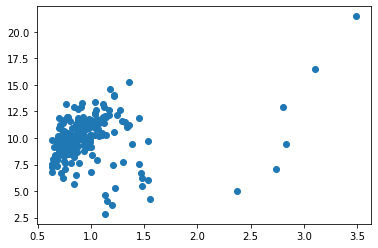

In [137]:
plt.scatter(df['metric1'], df['metric2'])